# Comparison of multiple pipelines and datasets with P300

In this second notebook, we will use P300 paradigm to compare multiple datasets and multiple pipelines. We choose datasets from the BNCI repository.

Please make sure you have verified your installation with the notebook `0_Minischool_Verify_Installation`.

## Selecting datasets

The datasets already defined in MOABB are listed in the [documentation](https://neurotechx.github.io/moabb/api.html). It is also possible to check the [MOABB wiki](https://github.com/NeuroTechX/moabb/wiki/Datasets-Support) for comparative information.

Here we will use two P300 datasets from BNCI:

In [1]:
from moabb.datasets import BNCI2014_008, BNCI2014_009

datasets = [BNCI2014_008(), BNCI2014_009()] 

In [2]:
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.spatialfilters import Xdawn
from pyriemann.estimation import XdawnCovariances
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


pipelines = {}
pipelines['tgsp+svm'] = make_pipeline(XdawnCovariances(estimator='lwf'), 
                                      TangentSpace(metric='riemann'), 
                                      SVC(kernel='linear'))
pipelines['MDM'] = make_pipeline(XdawnCovariances(estimator='lwf'),
                            MDM(metric='riemann', n_jobs=-1))

In [3]:
from moabb.paradigms import P300

paradigm = P300()


In [4]:
from moabb.evaluations import WithinSessionEvaluation

evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=False)

In [ ]:
results = evaluation.process(pipelines) 

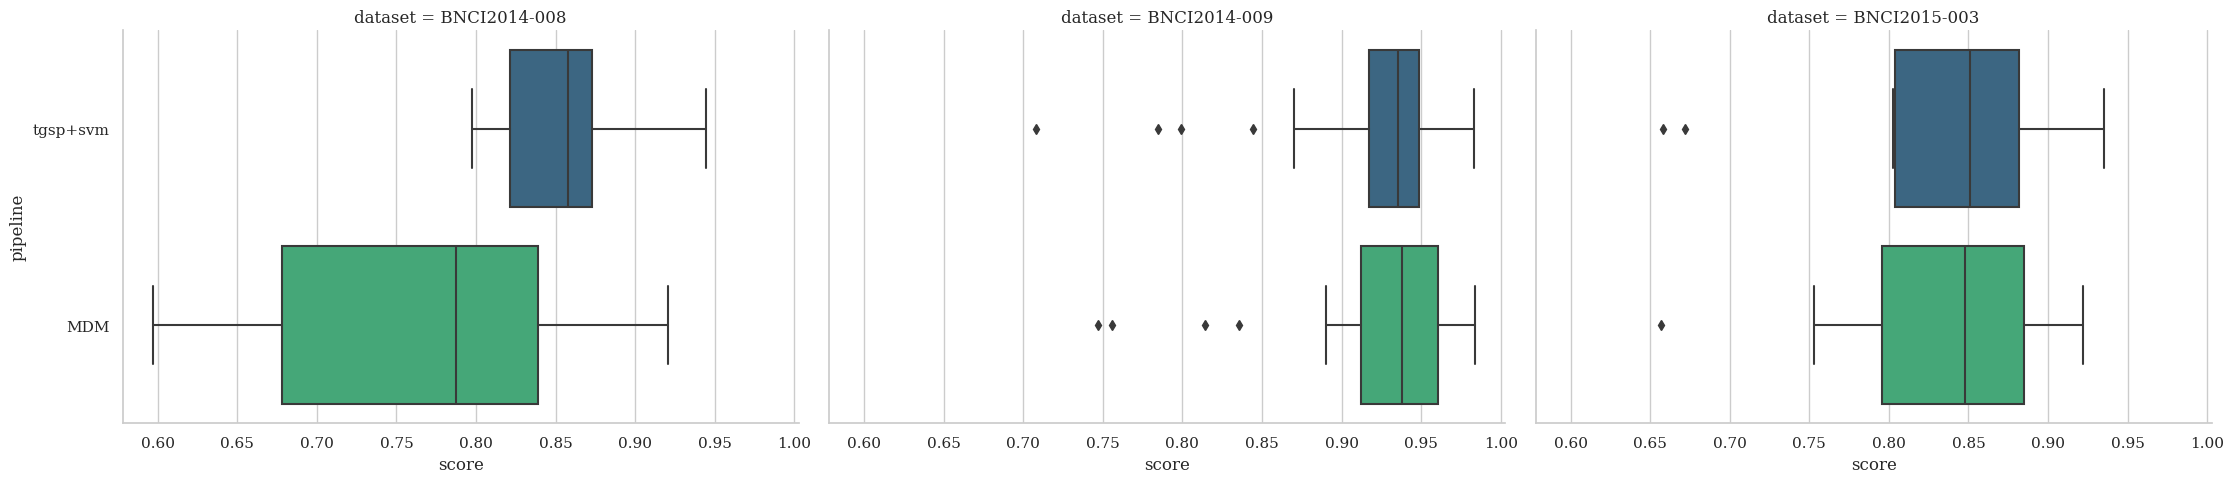

In [6]:
import seaborn as sns

g = sns.catplot(kind="box", x="score", y="pipeline", col="dataset", aspect=1.5, data=results, orient='h', palette='viridis')

Until now, we have always plotted the results using the seaborn package and creating the figure by ourselves. MOABB also offers some functionalities for analysing the results obtained after running an evaluation procedure.

# Advanced statistical analysis and meta-analysis

For instance, we may create a plot comparing the results with two classification algorithms as in:

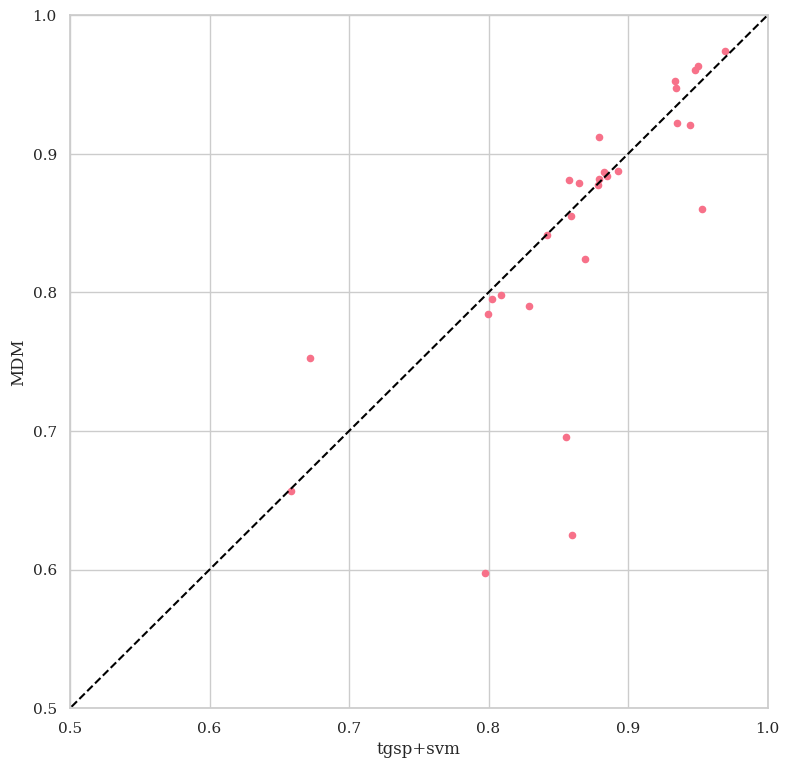

In [7]:
from moabb.analysis.plotting import paired_plot

alg1 = 'tgsp+svm'
alg2 = 'MDM'
fig = paired_plot(results, alg1, alg2)
fig.set_size_inches(9,9)

N.B.: MOABB collapses the values from different sessions into a single average score, which is why we have the impression of having much less points than it should in the plot.

We may also do statistical analysis on the results and plot them with MOABB. For this, we need to first generate an auxiliary dataframe containing all the statistics describing the results and, then, use it as input.

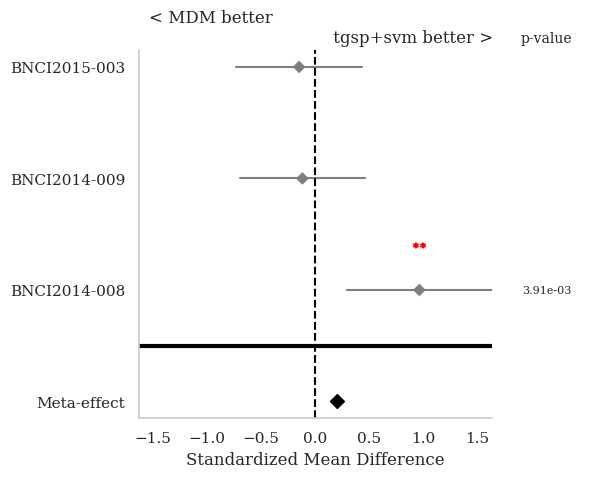

In [8]:
from moabb.analysis.meta_analysis import compute_dataset_statistics
from moabb.analysis.plotting import meta_analysis_plot

stats_df = compute_dataset_statistics(results)
alg1 = 'tgsp+svm'
alg2 = 'MDM'
fig = meta_analysis_plot(stats_df, alg1, alg2)
fig.set_size_inches(6, 5)

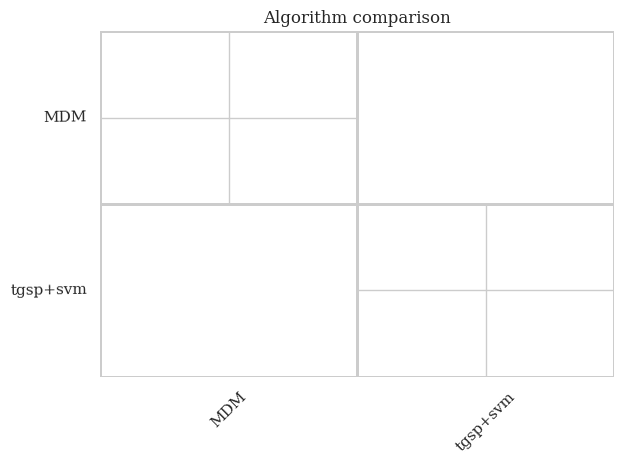

In [12]:
from moabb.analysis.meta_analysis import find_significant_differences
from moabb.analysis.plotting import summary_plot

P, T = find_significant_differences(stats_df)
_ = summary_plot(P, T)

# Adapting MOABB to your need

Here are some exercices to introduce some useful possibilities offered by MOABB. 


## Add new datasets in the evaluation (level: easy 🤗)

Use the code above to add another dataset in your evaluation

In [ ]:
from moabb.datasets import BNCI2015_003

datasets = [BNCI2014_008(), BNCI2014_009(), BNCI2015_003()]
paradigm = P300()
evaluation = WithinSessionEvaluation(paradigm=paradigm, datasets=datasets, overwrite=False)

results = evaluation.process(pipelines)

## Creating your own pipeline (level: intermediate 🤔)

The first is to create your machine learning pipeline, according to your need. As MOABB use a sklearn-like API for defining pipelines, it is easy to follow the [sklearn tutorial](https://scikit-learn.org/stable/developers/develop.html)

In [ ]:
from mne.decoding import Vectorizer

labels_dict = {"Target": 1, "NonTarget": 0}

your_pipelines = {}
your_pipelines["RG+LDA"] = make_pipeline(
    XdawnCovariances(
        nfilter=2, classes=[labels_dict["Target"]], estimator="lwf", xdawn_estimator="scm"
    ),
    TangentSpace(),
    LDA(solver="lsqr", shrinkage="auto"),
)

your_pipelines["Xdw+LDA"] = make_pipeline(
    Xdawn(nfilter=2, estimator="scm"), Vectorizer(), LDA(solver="lsqr", shrinkage="auto")
)

paradigm = P300(resample=128)

dataset = BNCI2014_009()
dataset.subject_list = dataset.subject_list[:2]
datasets = [dataset]
overwrite = True  # set to True if we want to overwrite cached results

evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="examples", overwrite=overwrite
)

results = evaluation.process(your_pipelines)

## Use learning curve (level intermediate 🤔)

Based on the example from the [MOABB gallery](https://neurotechx.github.io/moabb/auto_examples/index.html#evaluation-with-learning-curve) and the [documentation](https://neurotechx.github.io/moabb/generated/moabb.evaluations.WithinSessionEvaluation.html#moabb.evaluations.WithinSessionEvaluation), create an evaluation with an increasing number of sample. For example, using only 1%, 5% and 10% of the data to train. 

In [ ]:
import numpy as np

your_pipelines = {}
your_pipelines["RG+LDA"] = make_pipeline(
    XdawnCovariances(
        nfilter=2, classes=[labels_dict["Target"]], estimator="lwf", xdawn_estimator="scm"
    ),
    TangentSpace(),
    LDA(solver="lsqr", shrinkage="auto"),
)

your_pipelines["Xdw+LDA"] = make_pipeline(
    Xdawn(nfilter=2, estimator="scm"), Vectorizer(), LDA(solver="lsqr", shrinkage="auto")
)

paradigm = P300(resample=128)

dataset = BNCI2014_009()
dataset.subject_list = dataset.subject_list[:2]
datasets = [dataset]
overwrite = True  # set to True if we want to overwrite cached results
data_size = dict(policy="ratio", value=[0.01, 0.05, 0.1])
# When the training data is sparse, perform more permutations than when we have a lot of data
n_perms = np.floor(np.geomspace(20, 2, len(data_size["value"]))).astype(int)
np.random.seed(7536298)

evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=datasets, suffix="examples", overwrite=overwrite, data_size=data_size,n_perms=n_perms,
)

results = evaluation.process(your_pipelines)

/var/folders/d4/_4q888f9053cl142j5r3tmy00000gq/T/ipykernel_51570/1151224741.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  r = results.groupby(["pipeline", "subject", "data_size"]).mean().reset_index()


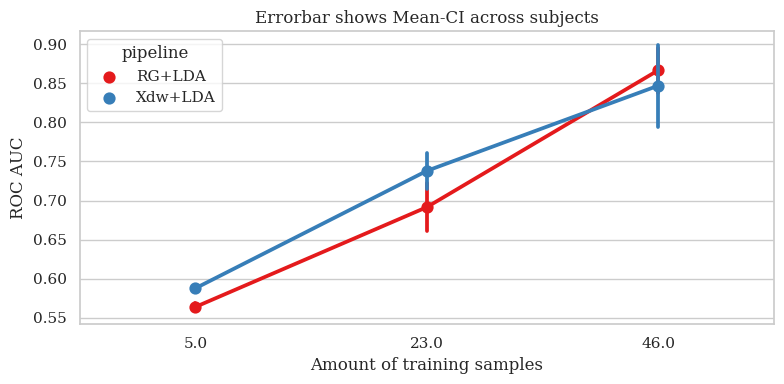

In [18]:
# plot results
import matplotlib.pyplot as plt

fig, ax = plt.subplots(facecolor="white", figsize=[8, 4])

n_subs = len(dataset.subject_list)

if n_subs > 1:
    r = results.groupby(["pipeline", "subject", "data_size"]).mean().reset_index()
else:
    r = results

sns.pointplot(data=r, x="data_size", y="score", hue="pipeline", ax=ax, palette="Set1")

errbar_meaning = "subjects" if n_subs > 1 else "permutations"
title_str = f"Errorbar shows Mean-CI across {errbar_meaning}"
ax.set_xlabel("Amount of training samples")
ax.set_ylabel("ROC AUC")
ax.set_title(title_str)
fig.tight_layout()
plt.show()